# Experimental Data (Testing)

In [1]:
base='Geo_5ulh_pre/'
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
files=os.listdir(base)

full_files=[]
sorted_frames = sorted(files, key=lambda x: int(x[3:-4]))
for i in range(len(sorted_frames)):
    file = base+sorted_frames[i]
    full_files.append(file)

In [2]:
#torch.cuda.empty_cache()
import gc
gc.collect()

0

# Load Test Images

In [3]:
full_files[0]

'Geo_5ulh_pre/tst0.tif'

In [4]:
import cv2
import numpy as np
import cv2
from joblib import Parallel, delayed
l=500
from PIL import Image
# def process_file(file_path):
#     image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
#     resized_image = cv2.resize(image, [l, l])
#     return resized_image
def process_file(file_path):
    image = np.array(Image.open(file_path))
    resized_image = cv2.resize(image, [l, l])
    resized_image = (resized_image-np.min(resized_image))/(np.max(resized_image)-np.min(resized_image))
    return resized_image

def parallel_image_processing(full_files):
    num_files = len(full_files)
    images = np.zeros([num_files, l, l])

    results = Parallel(n_jobs=16)(delayed(process_file)(file_path) for file_path in full_files)

    for i, resized_image in enumerate(results):
        images[i] = resized_image

    return images

images = parallel_image_processing(full_files)

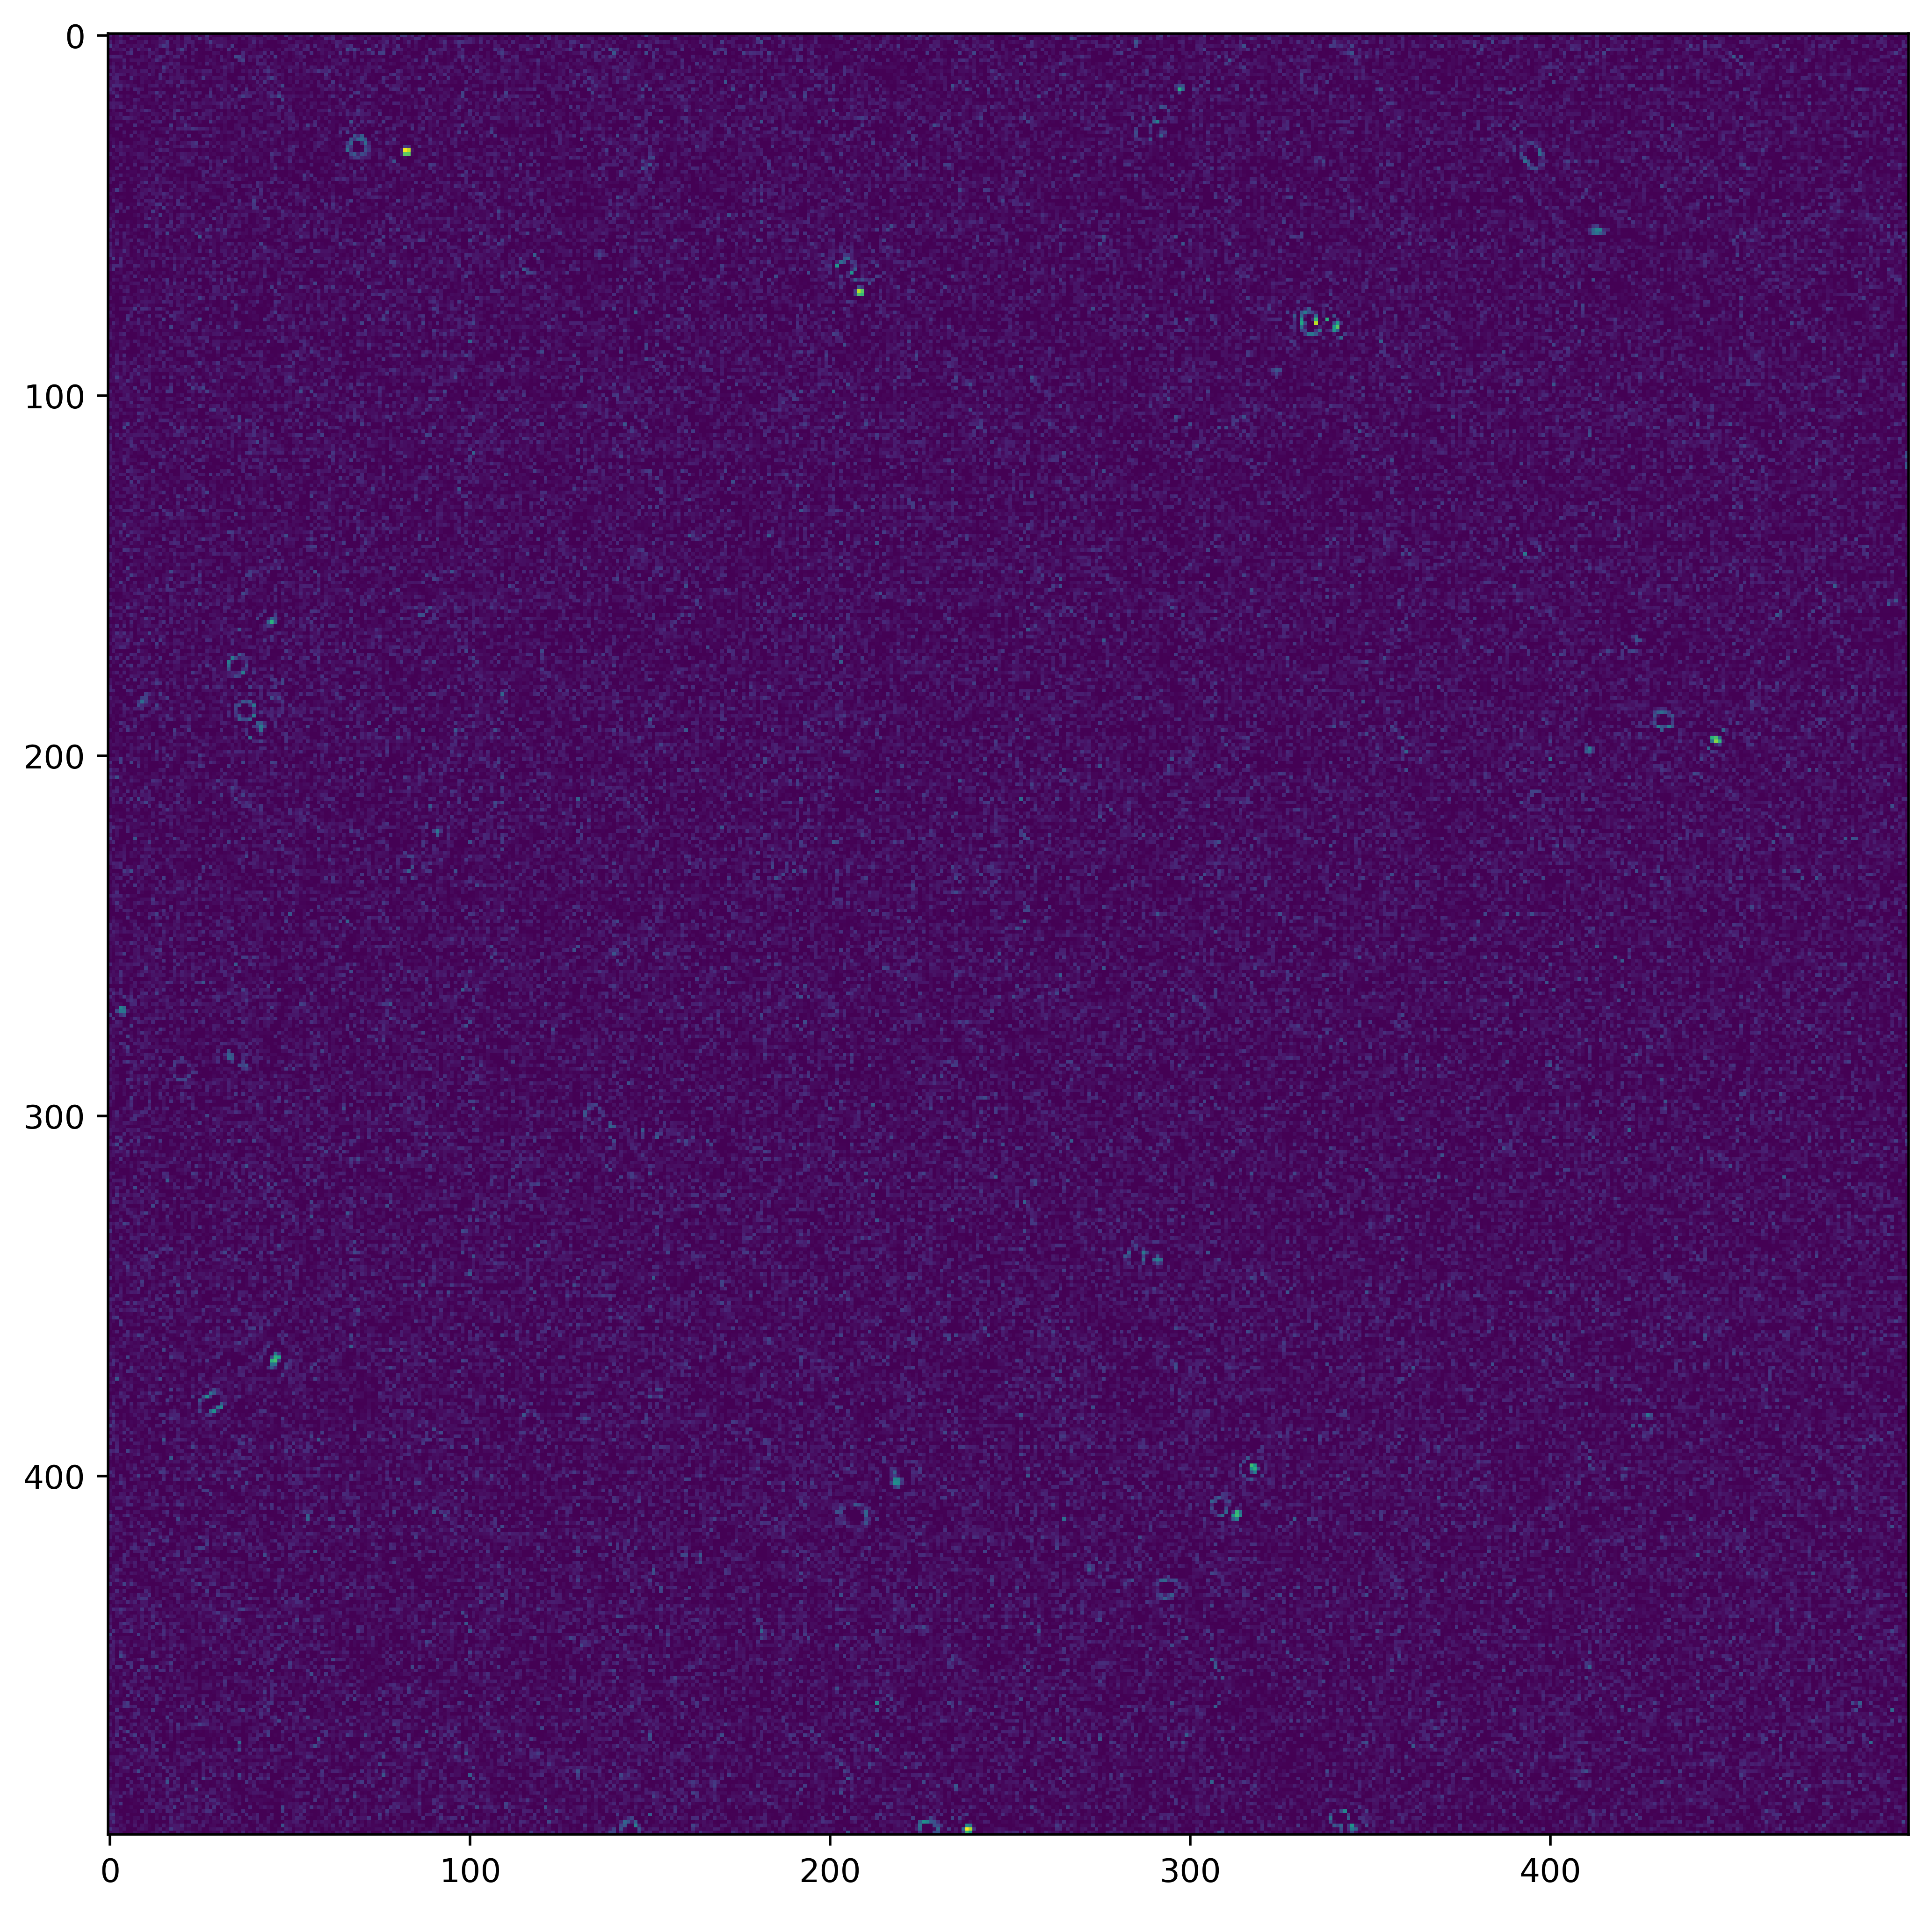

In [6]:
plt.figure(figsize=(10,10),dpi=500)
plt.imshow(images[-1])


In [7]:
# for i in range(len(images)):
#     images[i] = 1-images[i]
    

In [8]:
np.mean(images)

0.023662597770498724

# Speed Models

In [9]:
from torch import nn
import torch.nn.functional as F

class Patch_model2(nn.Module):
    def __init__(self):
        super(Patch_model2, self).__init__()
        self.m0 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0.0,num_classes=2000,pretrained=True)
        self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

        self.fc1=nn.Linear(2000, 1000)
        self.fc2=nn.Linear(1000,500)


    def forward(self, x):
        l2=224
        x1 = x[:,:,0:l2,0:l2]
        x2 = x[:,:,0:l2,l2:]
        x3 = x[:,:,l2:,0:l2]
        x4 = x[:,:,l2:,l2:]
        #torch.cuda.empty_cache()
        #gc.collect()
        x = F.gelu(self.m0(x))
        x1 = F.gelu(self.m1(x1))
        x2 = F.gelu(self.m2(x2))
        x3 = F.gelu(self.m3(x3))
        x4 = F.gelu(self.m4(x4))
        x0 = torch.cat([x1,x2,x3,x4],dim=1)
        del x1,x2, x3, x4
        x = x*x0
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x#,x2,x3,x4

class Patch_model3(nn.Module):
    def __init__(self):
        super(Patch_model3, self).__init__()
        self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

        self.fc1=nn.Linear(2000, 1000)
        self.fc2=nn.Linear(1000,500)


    def forward(self, x):
        l2=224
        x1 = x[:,:,0:l2,0:l2]
        x2 = x[:,:,0:l2,l2:]
        x3 = x[:,:,l2:,0:l2]
        x4 = x[:,:,l2:,l2:]
        #torch.cuda.empty_cache()
        #gc.collect()
        x1 = F.gelu(self.m1(x1))
        x2 = F.gelu(self.m2(x2))
        x3 = F.gelu(self.m3(x3))
        x4 = F.gelu(self.m4(x4))
        x = torch.cat([x1,x2,x3,x4],dim=1)
        del x1,x2, x3, x4
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x#,x2,x3,x4

class Patch_model4(nn.Module):
    def __init__(self):
        super(Patch_model4, self).__init__()
        self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

        self.fc0=nn.Linear(2000, 500)
        #self.fc2=nn.Linear(1000,500)


    def forward(self, x):
        l2=224
        x1 = x[:,:,0:l2,0:l2]
        x2 = x[:,:,0:l2,l2:]
        x3 = x[:,:,l2:,0:l2]
        x4 = x[:,:,l2:,l2:]
        #torch.cuda.empty_cache()
        #gc.collect()
        x1 = F.gelu(self.m1(x1))
        x2 = F.gelu(self.m2(x2))
        x3 = F.gelu(self.m3(x3))
        x4 = F.gelu(self.m4(x4))
        x = torch.cat([x1,x2,x3,x4],dim=1)
        del x1,x2, x3, x4
        #x = F.gelu(self.fc1(x))
        x = self.fc0(x)
        return x#,x2,x3,x4


class Patch_model(nn.Module):
    def __init__(self):
        super(Patch_model, self).__init__()
        self.m0 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0.0,num_classes=2000,pretrained=True)
        self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

        self.fc1=nn.Linear(4000, 1000)
        self.fc2=nn.Linear(1000,500)


    def forward(self, x):
        l2=224
        x1 = x[:,:,0:l2,0:l2]
        x2 = x[:,:,0:l2,l2:]
        x3 = x[:,:,l2:,0:l2]
        x4 = x[:,:,l2:,l2:]
        #torch.cuda.empty_cache()
        #gc.collect()
        x = F.gelu(self.m0(x))
        x1 = F.gelu(self.m1(x1))
        x2 = F.gelu(self.m2(x2))
        x3 = F.gelu(self.m3(x3))
        x4 = F.gelu(self.m4(x4))
        x0 = torch.cat([x1,x2,x3,x4],dim=1)
        del x1,x2, x3, x4
        x = torch.cat([x,x0],dim=1)#x*x0
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x#,x2,x3,x4

class Net0(nn.Module):
    def __init__(self):
        super(Net0, self).__init__()
        self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)



    def forward(self, x):
        x = self.m1(x)


        return x#,x2,x3,x4

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.m1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0,num_classes=1000,pretrained=True)



    def forward(self, x):
        x = self.m1(x)


        return x#,x2,x3,x4

class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.m1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)



    def forward(self, x):
        x = self.m1(x)


        return x#,x2,x3,x4
    

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gc
from torch.optim.lr_scheduler import StepLR
import torchvision as tv
import timm
device='cuda'

model6 = Patch_model3()
model6.load_state_dict(torch.load('models/speed_model_volod1_patch_4x224px_dispBrown_4_21'))
model6.to(device).eval()

model7 = Patch_model()
model7.load_state_dict(torch.load('models/speed_model_Volo224-448_dispBrown_patch_v3'))
model7.to(device).eval()

model8 =Patch_model2()
model8.load_state_dict(torch.load('models/speed_model_Volo224-448_dispBrown_patch_v1'))
model8.to(device).eval()

model17 =Patch_model4()
model17.load_state_dict(torch.load('models/speed_model_patch448px_disp300_4_23_v2'))
model17.to(device).eval()


Patch_model4(
  (m1): VOLO(
    (patch_embed): PatchEmbed(
      (conv): Sequential(
        (0): Conv2d(40, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU(inplace=True)
      )
      (proj): Conv2d(64, 192, kernel_size=(4, 4), stride=(4, 4))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (network): ModuleList(
      (0): Sequential(
        (0): Outlooker(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=T

In [19]:
model5 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=.0,num_classes=1000,pretrained=False)
model5.load_state_dict(torch.load('models/speed_model_volod3_448px_dispBrown_4_22_v2'))
model5.to(device).eval()

model1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=.0,num_classes=1000,pretrained=False)
model1.load_state_dict(torch.load('models/speed_model_volod3_448px_dispBrown_4_22'))
model1.to(device).eval()

model2 = timm.create_model('twins_svt_small', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model2.load_state_dict(torch.load('models/speed_model_TwinsSvtSmall_500px_opposite_dispBrown_4_21'))
model2.to(device).eval()

model3 = timm.create_model('volo_d2_224', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model3.load_state_dict(torch.load('models/speed_model_volod1_224px_disp_4_21'))
model3.to(device).eval()

model4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model4.load_state_dict(torch.load('models/speed_model_volod1_224px_dispBrown_4_21'))
model4.to(device).eval()

model18 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model18.load_state_dict(torch.load('models/speed_model_384px_disp300_4_23'))
model18.to(device).eval()

model19 = timm.create_model('volo_d2_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model19.load_state_dict(torch.load('models/speed_model_384px_disp300_4_23_v2'))
model19.to(device).eval()

model20 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model20.load_state_dict(torch.load('models/speed_model_volod3_448px_disp300_4_25'))
model20.to(device).eval()

VOLO(
  (patch_embed): PatchEmbed(
    (conv): Sequential(
      (0): Conv2d(40, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (proj): Conv2d(64, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (network): ModuleList(
    (0): Sequential(
      (0): Outlooker(
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): OutlookAttention(
          (v): Linear

In [20]:
model9 = Net0()
model9.load_state_dict(torch.load('models/speed_model_Volo384_dispBrown_full'))
model9.to(device).eval()

model10 = Net0()
model10.load_state_dict(torch.load('models/speed_model_Volo384_dispBrown_fullv2'))
model10.to(device).eval()

model11 = Net0()
model11.load_state_dict(torch.load('models/speed_model_Volo384_dispBrown_fullv3'))
model11.to(device).eval()

model12 = Net0()
model12.load_state_dict(torch.load('models/speed_model_Volo384_dispBrown_full_new_v1'))
model12.to(device).eval()

model13 = Net2()
model13.load_state_dict(torch.load('models/speed_model_Volo448_dispBrown'))
model13.to(device).eval()

model14 = Net3()
model14.load_state_dict(torch.load('models/speed_model_Volo448_dispBrown_full'))
model14.to(device).eval()

model15 = timm.create_model('swinv2_small_window16_256', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model15.load_state_dict(torch.load('models/speed_model_patch_swin_256px_dispBrown_4_23'))
model15.to(device).eval()

model16 = timm.create_model('botnet26t_256', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model16.load_state_dict(torch.load('models/speed_model_ByobNet26_256px_dispBrown_4_23'))
model16.to(device).eval()

ByobNet(
  (stem): Stem(
    (conv1): ConvNormAct(
      (conv): Conv2d(40, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (conv2): ConvNormAct(
      (conv): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (conv3): ConvNormAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)


# Test Dataloader

In [21]:

# m1 = timm.create_model('regnety_016', in_chans=40, drop_path_rate=.0,num_classes=4000,pretrained=True)
# model=Net2()
# model.to(device)
# Define your custom dataset

class TestDataset2(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]

        return image.float()

In [13]:
timm.list_models()

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [14]:
#Paen
#images = images[22:,:,:].reshape([(images.shape[0]-22)//40,40,500,500])
#Geo
#images = images[:-39,:,:].reshape([(images.shape[0]-39)//40,40,500,500])
images = images.reshape([(images.shape[0])//40,40,500,500])
images.shape

(80, 40, 500, 500)

C:\Users\marcb\AppData\Local\Temp\ipykernel_27276\1521451215.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images)


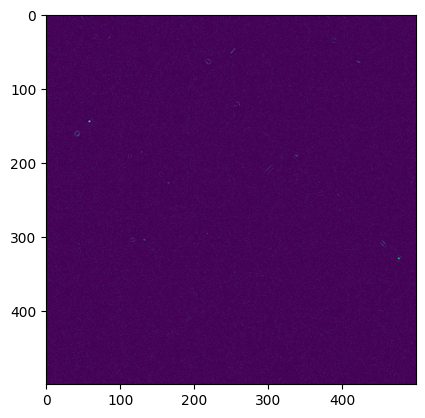

In [22]:
import torch
images = torch.tensor(images)
dataset_test = TestDataset2(images)#  xtorch_test, distr_torch_test, scales_test2)
batch_size = 10
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=0)
x = next(iter(test_dataloader))
plt.imshow(x[0,39,:,:])

# Speed Classifier

In [23]:
class Net0(nn.Module):
    def __init__(self):
        super(Net0, self).__init__()
        self.m1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0.8,num_classes=4,pretrained=True)

    def forward(self, x):
        x = F.softmax(self.m1(x),dim=1)
        return x

class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.9,num_classes=4,pretrained=True)

    def forward(self, x):
        x = F.softmax(self.m1(x),dim=1)
        return x

class Net7(nn.Module):
    def __init__(self):
        super(Net7, self).__init__()
        self.m1 = timm.create_model('regnetx_160.pycls_in1k', in_chans=40,drop_path_rate=0.6, num_classes=4,pretrained=True)

    def forward(self, x):
        x = F.softmax(self.m1(x),dim=1)
        return x

class0 = Net0()
class0.load_state_dict(torch.load('models/speed_classifier_volod3_448px_disp200'))
class0.to(device).eval()

class1 = Net7()
class1.load_state_dict(torch.load('models/speed_classifier_regnetx120_500px_disp_all'))
class1.to(device).eval()

class2 = Net4()
class2.load_state_dict(torch.load('models/speed_classifier_volod1_224px_disp_all'))
class2.to(device).eval()


Net4(
  (m1): VOLO(
    (patch_embed): PatchEmbed(
      (conv): Sequential(
        (0): Conv2d(40, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU(inplace=True)
      )
      (proj): Conv2d(64, 192, kernel_size=(4, 4), stride=(4, 4))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (network): ModuleList(
      (0): Sequential(
        (0): Outlooker(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
   

In [26]:
class0.eval()
class1.eval()
class2.eval()

import torchvision
outputs=[]

with torch.no_grad():
    for x in test_dataloader:
        x1 = torchvision.transforms.functional.resize(x, 448)
        x2 = torchvision.transforms.functional.resize(x, 224)

        out0 =(class0((x1).to(device)).detach().cpu().numpy())
        out1 =(class1((x).to(device)).detach().cpu().numpy())
        out2 =(class2((x2).to(device)).detach().cpu().numpy())
        out = (out0*27+out1*3+out2)/31

        outputs.append(out)
mean_out=np.mean(np.vstack(outputs),0)

In [37]:
class_num = np.argmax(mean_out)
class_num

1

In [48]:
import torchvision
outputs=[]
outputs2=[]
torch.cuda.empty_cache()
gc.collect()
def interpolate_vectors(vector, target_length):
    current_length = len(vector)
    # Create a new x-axis with the desired length
    new_x = np.linspace(0, current_length - 1, target_length)
    # Create the old x-axis based on the current length
    old_x = np.arange(current_length)
    # Perform linear interpolation
    interpolated_vector = np.interp(new_x, old_x, vector)
    return interpolated_vector
    
#model.eval()
model1.eval()
model2.eval()
model3.eval()
model4.eval()
model5.eval()
model6.eval()
model7.eval()
model8.eval()
model9.eval()
model10.eval()
model11.eval()
model12.eval()
model13.eval()
model14.eval()
model15.eval()
model16.eval()
model17.eval()
model18.eval()
model19.eval()
model20.eval()



with torch.no_grad():
    for x in test_dataloader:
        x=1-x
        x1 = torchvision.transforms.functional.resize(x, 448)
        x2 = torchvision.transforms.functional.resize(x, 224)
        x3 = torchvision.transforms.functional.resize(x, 384)
        x4 = torchvision.transforms.functional.resize(x, 256)
        #out1_1000 = (model1((1-x1).to(device)).detach().cpu().numpy())
        #out1 = np.zeros([batch_size,500])
        #for i in range(len(out1)):
        #    out1[i,:] = interpolate_vectors(out1_1000[i,:],500)
        out2 = np.sort(model2((x).to(device)).detach().cpu().numpy())
        out11 = np.sort(model11((x3).to(device)).detach().cpu().numpy())
        #out10 =(model10((x3).to(device)).detach().cpu().numpy())
        out9 = np.sort(model9((x3).to(device)).detach().cpu().numpy())
        out8 = np.sort(model8((x1).to(device)).detach().cpu().numpy())
        out7 =np.sort(model7((x1).to(device)).detach().cpu().numpy())
        out6 = np.sort(model6((1-x1).to(device)).detach().cpu().numpy())
        out3 = np.sort(model3((1-x2).to(device)).detach().cpu().numpy())
        out4 = np.sort(model4((x2).to(device)).detach().cpu().numpy())
        #out5 = np.sort(model5((x1).to(device)).detach().cpu().numpy())
        out12 = np.sort(model12((x3).to(device)).detach().cpu().numpy())
        #out0 = (model((1-x1).to(device)).detach().cpu().numpy())
        out13_1000 = np.sort(model13((x1).to(device)).detach().cpu().numpy())
        out13 = np.zeros([batch_size,500])
        for i in range(len(out13)):
            out13[i,:] = interpolate_vectors(out13_1000[i,:],500)
        out14 = np.sort(model14((x1).to(device)).detach().cpu().numpy())
        out15 = np.sort(model15((1-x4).to(device)).detach().cpu().numpy())
        #out16 = (model16((1-x4).to(device)).detach().cpu().numpy())
        out17 = np.sort(model17((1-x1).to(device)).detach().cpu().numpy())
        out18 = np.sort(model18((x3).to(device)).detach().cpu().numpy())
        out19 = np.sort(model19((1-x3).to(device)).detach().cpu().numpy())
        out20 = np.sort(model20((1-x1).to(device)).detach().cpu().numpy())

        out14_2 = np.sort(model14((1-x1).to(device)).detach().cpu().numpy())
        out15_2 = np.sort(model15((x4).to(device)).detach().cpu().numpy())
        #out16 = (model16((1-x4).to(device)).detach().cpu().numpy())
        out17_2 = np.sort(model17((x1).to(device)).detach().cpu().numpy())
        out18_2 = np.sort(model18((1-x3).to(device)).detach().cpu().numpy())
        out19_2 = np.sort(model19((x3).to(device)).detach().cpu().numpy())
        out20_2 = np.sort(model20((x1).to(device)).detach().cpu().numpy())
        if class_num==3:
            #1ulh
            #class 3 (x<3)
            out=(out4*6+np.sort(out14)*15+np.sort(out17_2)*20+np.sort(out18_2)*2+np.sort(out19_2)*25+np.sort(out20)*10+np.sort(out8)*2.5+np.sort(out9)*13.5)/106
        elif class_num==2:
            #class 2 (3<x<6)
            out=(out2*10+out3*4+out4*16+out6*4+out7*1+out11*10+out12*5+out13*4+out14*1+out15*2+out17*10+out18*8+out19*26+out20*2+out9*3)/95
        elif class_num==1:
            #5ulh
            #class 1 (6<x<10)
            out=(out3*8+out4*32+out8*15+out11*33+out13*50+out14*5+out18*17+out19*17+out6*5+out2*5)/156
            
        else:
            #class 0 (x>10)
            out=(out3*8+out4*64+out8*15+out11*33+out13*50+out14*5+out18*17+out19*17+out6*5+out2*10)/180

        outputs.append(out)
        #outputs2.append(out2)


In [49]:
out = np.reshape(np.hstack(outputs),[40000 ,])
out = out[out>0]
out.shape

(40000,)

In [50]:
np.mean(out)

13.033579719100723

# Calculate Speeds from Experimental Particle Tracking Data

In [44]:
directory='../tmate_trajectories/'
filename = os.listdir(directory)[4]
print(filename)
df = pd.read_csv(os.path.join(directory,filename),header=0, skiprows=[1,2,3])
#df.Positio
tracks = df.TRACK_ID.unique()
vels=1
for i in range(len(tracks)):
    idx = tracks[i]
    if df[df.TRACK_ID==idx].sort_values(by='FRAME').FRAME.iloc[-1] < (images.shape[0]*images.shape[1]):
        posx = .325*df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_X
        posy = .325*df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_Y
        
        #posx[posx==0]=np.nan
        #posy[posy==0]=np.nan
        vel = (np.sqrt(posx.diff()**2+posy.diff()**2)/.12).dropna()
    
        vels = np.hstack([vels, vel])
        
vels=vels[~np.isnan(vels)]
vels = vels[vels<800]
vels = vels[vels>0]

geo_5ulh_001.csv


(4e-05, 0.1)

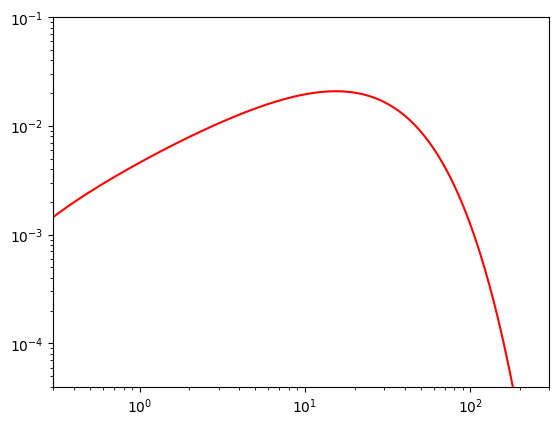

In [51]:
from scipy.stats import exponweib,lognorm, beta, betaprime, norm
#new_out=(out6*4+out2*1+out9*.5+out1*1+out10*2.5)/9
a,b,c,d= betaprime.fit(np.sort(out*.325/.12))
xtorch= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), 4000)
distr_torch=betaprime.pdf(xtorch, a,b,c,d)
plt.plot(xtorch,distr_torch,c='r')
plt.xscale('log')
plt.yscale('log')
plt.xlim([3e-1,3e2])
plt.ylim([4e-5,.1])
#15, 16, 20, 9, 3, 10
#3, 4, 6, 7, 12, 13, 17, 18, 19, 20

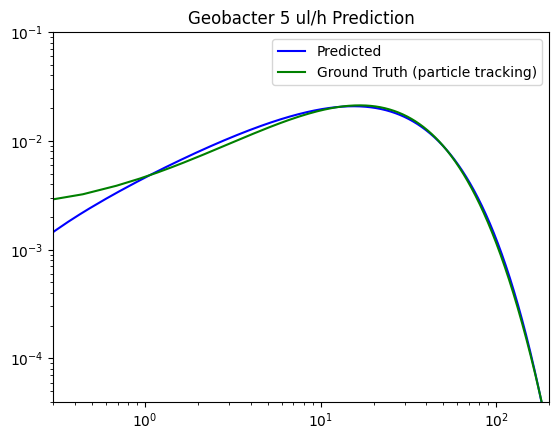

In [52]:
a,b,c,d= betaprime.fit(np.sort(vels))
xvel= np.linspace(betaprime.ppf(0.0001, a,b,c,d),
                betaprime.ppf(0.9999, a,b,c,d), 1000)
distr_vel=betaprime.pdf(xvel, a,b,c,d)
plt.plot(xtorch,distr_torch,c='b')
plt.plot(xvel,distr_vel,c='g')
plt.xscale('log')
plt.yscale('log')
plt.xlim([3e-1,2e2])
plt.ylim([4e-5,.1])
plt.title('Geobacter 5 ul/h Prediction')
plt.legend(['Predicted', 'Ground Truth (particle tracking)'])

# Angle Model

In [54]:
def calculate_angles_test(x_arr, y_arr):
    traj_stats=[]
    x_diff = np.diff(x_arr)
    y_diff = np.diff(y_arr)
    #print(x_diff.shape)
    angles=np.zeros((len(x_diff),1))
    for i in range(len(x_diff)-1):
        theta_1=np.arctan(y_diff[i]/x_diff[i])
        theta_2=np.arctan(y_diff[i+1]/x_diff[i+1])
        angles[i]=(theta_2-theta_1)*(180/np.pi)
        traj_stats.append([angles])
    
    angles=np.abs(angles[~np.isnan(angles)])
    #angles = interpolate_vectors(np.sort(angles), target_length)
    angles[angles==0]=0.1
    return angles

In [55]:
directory='../tmate_trajectories/'
filename = os.listdir(directory)[4]
print(filename)
df = pd.read_csv(os.path.join(directory,filename),header=0, skiprows=[1,2,3])
#df.Positio
tracks = df.TRACK_ID.unique()
angles=1
for i in range(len(tracks)):
    idx = tracks[i]
    if df[df.TRACK_ID==idx].sort_values(by='FRAME').FRAME.iloc[-1] < (images.shape[0]*images.shape[1]):
        posx = df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_X
        posy = df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_Y

        angle_array = calculate_angles_test(np.array(posx),np.array(posy))
        
        #posx[posx==0]=np.nan
        #posy[posy==0]=np.nan
        #vel = (np.sqrt(posx.diff()**2+posy.diff()**2)/.12).dropna()
    
        angles = np.hstack([angles, angle_array])

geo_5ulh_001.csv


C:\Users\marcb\AppData\Local\Temp\ipykernel_27276\1466331465.py:9: RuntimeWarning: invalid value encountered in scalar divide
  theta_2=np.arctan(y_diff[i+1]/x_diff[i+1])
C:\Users\marcb\AppData\Local\Temp\ipykernel_27276\1466331465.py:8: RuntimeWarning: invalid value encountered in scalar divide
  theta_1=np.arctan(y_diff[i]/x_diff[i])
C:\Users\marcb\AppData\Local\Temp\ipykernel_27276\1466331465.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  theta_2=np.arctan(y_diff[i+1]/x_diff[i+1])
C:\Users\marcb\AppData\Local\Temp\ipykernel_27276\1466331465.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  theta_1=np.arctan(y_diff[i]/x_diff[i])


In [56]:
angles=np.abs(angles[~np.isnan(angles)])
angles = angles[angles>0]

In [70]:


class Net0(nn.Module):
    def __init__(self):
        super(Net0, self).__init__()
        self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)

    def forward(self, x):
        x = self.m1(x)

model0 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)
model0.load_state_dict(torch.load('models/turn_angle_model_volod3_448px_disp_all_4_25'))
model0.to(device).eval()

model1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)
model1.load_state_dict(torch.load('models/turn_angle_model_Volod1_384_dispBrownv4'))
model1.to(device).eval()

model2 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)
model2.load_state_dict(torch.load('models/turn_angle_model_Volod1_384_dispBrownv3'))
model2.to(device).eval()

model3 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)
model3.load_state_dict(torch.load('models/turn_angle_model_Volod1_384_dispBrownv2'))
model3.to(device).eval()

model4 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)
model4.load_state_dict(torch.load('models/turn_angle_model_Volod1_384_dispBrown'))
model4.to(device).eval()

# model5 = Net()
# model5.load_state_dict(torch.load('models/turn_angle_model'))
# model5.to(device).eval()

VOLO(
  (patch_embed): PatchEmbed(
    (conv): Sequential(
      (0): Conv2d(40, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (proj): Conv2d(64, 192, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (network): ModuleList(
    (0): Sequential(
      (0): Outlooker(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): OutlookAttention(
          (v): Linear

In [69]:
model5

Net(
  (fc2): Conv2d(100, 200, kernel_size=(1, 1), stride=(2, 2))
  (d1): Dropout(p=0.2, inplace=False)
  (fc1): Conv2d(40, 100, kernel_size=(1, 1), stride=(2, 2))
  (d2): Dropout(p=0.2, inplace=False)
  (fc5): Conv2d(200, 5, kernel_size=(1, 1), stride=(1, 1))
  (fc6): Linear(in_features=312500, out_features=1000, bias=True)
  (d3): Dropout(p=0.2, inplace=False)
  (fc7): Linear(in_features=100, out_features=4, bias=True)
  (fc8): Linear(in_features=2000, out_features=1000, bias=True)
)

In [74]:
model0.eval()
model1.eval()
model2.eval()
model3.eval()
model4.eval()
# model9.eval()
# # model10.eval()
# model11.eval()
import torchvision
outputs=[]

with torch.no_grad():
    for x in test_dataloader:
        x1 = torchvision.transforms.functional.resize(x, 448)
        x2 = torchvision.transforms.functional.resize(x, 384)

        out0 =np.sort(model0((x1).to(device)).detach().cpu().numpy())
        out1 =np.sort(model1((x2).to(device)).detach().cpu().numpy())
        out2 =np.sort(model2((x2).to(device)).detach().cpu().numpy())
        out3 =np.sort(model3((x2).to(device)).detach().cpu().numpy())
        out4 =np.sort(model4((x2).to(device)).detach().cpu().numpy())

        out = (out0+out1+out2+out3+out4)/5

        outputs.append(out)

In [76]:
out = np.abs(np.reshape(np.hstack(outputs),[40000 ,]))
out=out[out>0]
out.shape

(40000,)

In [84]:
np.mean(out0)

19.377863

In [83]:
np.mean(angles)

19.334786925856555

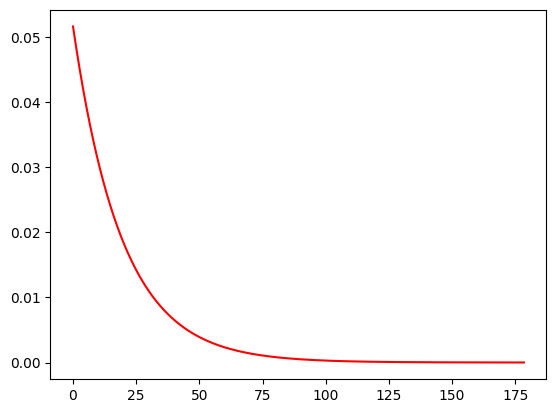

In [87]:
from scipy.stats import exponweib,lognorm, beta, betaprime, norm, expon
#new_out=(out6*4+out2*1+out9*.5+out11*1+out10*2.5)/9
a,b= expon.fit(np.sort(out0))
g5xtorch= np.linspace(expon.ppf(0.0001, a,b),
                expon.ppf(0.9999, a,b), 4000)
g5distr_torch=expon.pdf(g5xtorch, a,b)
plt.plot(g5xtorch,g5distr_torch,c='r')

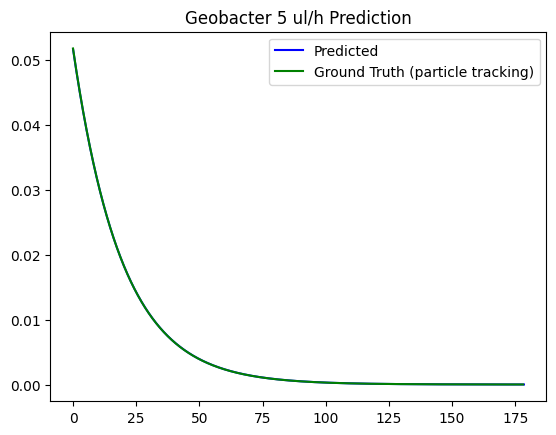

In [89]:
a,b= expon.fit(np.sort(angles))
g5xvel= np.linspace(expon.ppf(0.0001, a,b),
                expon.ppf(0.9999, a,b), 4000)
g5distr_vel=expon.pdf(g5xvel, a,b)
plt.plot(g5xtorch,g5distr_torch,c='b')
plt.plot(g5xvel,g5distr_vel,c='g')

plt.title('Geobacter 5 ul/h Prediction')
plt.legend(['Predicted', 'Ground Truth (particle tracking)'])

In [ ]:
a,b= expon.fit(np.sort(angles))
g5xvel= np.linspace(expon.ppf(0.0001, a,b),
                expon.ppf(0.9999, a,b), 4000)
g5distr_vel=expon.pdf(g5xvel, a,b)
plt.plot(g5xtorch,g5distr_torch,c='b')
plt.plot(g5xvel,g5distr_vel,c='g')

plt.title('Geobacter 1 ul/h Prediction')
plt.legend(['Predicted', 'Ground Truth (particle tracking)'])

# Velocity Model

## Vx

In [90]:
from torch import nn
import torch.nn.functional as F

class Patch_model2(nn.Module):
    def __init__(self):
        super(Patch_model2, self).__init__()
        self.m0 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0.0,num_classes=2000,pretrained=True)
        self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

        self.fc1=nn.Linear(2000, 1000)
        self.fc2=nn.Linear(1000,500)


    def forward(self, x):
        l2=224
        x1 = x[:,:,0:l2,0:l2]
        x2 = x[:,:,0:l2,l2:]
        x3 = x[:,:,l2:,0:l2]
        x4 = x[:,:,l2:,l2:]
        #torch.cuda.empty_cache()
        #gc.collect()
        x = F.gelu(self.m0(x))
        x1 = F.gelu(self.m1(x1))
        x2 = F.gelu(self.m2(x2))
        x3 = F.gelu(self.m3(x3))
        x4 = F.gelu(self.m4(x4))
        x0 = torch.cat([x1,x2,x3,x4],dim=1)
        del x1,x2, x3, x4
        x = x*x0
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x#,x2,x3,x4

class Patch_model3(nn.Module):
    def __init__(self):
        super(Patch_model3, self).__init__()
        self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

        self.fc1=nn.Linear(2000, 1000)
        self.fc2=nn.Linear(1000,500)


    def forward(self, x):
        l2=224
        x1 = x[:,:,0:l2,0:l2]
        x2 = x[:,:,0:l2,l2:]
        x3 = x[:,:,l2:,0:l2]
        x4 = x[:,:,l2:,l2:]
        #torch.cuda.empty_cache()
        #gc.collect()
        x1 = F.gelu(self.m1(x1))
        x2 = F.gelu(self.m2(x2))
        x3 = F.gelu(self.m3(x3))
        x4 = F.gelu(self.m4(x4))
        x = torch.cat([x1,x2,x3,x4],dim=1)
        del x1,x2, x3, x4
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x#,x2,x3,x4

class Patch_model4(nn.Module):
    def __init__(self):
        super(Patch_model4, self).__init__()
        self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

        self.fc0=nn.Linear(2000, 500)
        #self.fc2=nn.Linear(1000,500)


    def forward(self, x):
        l2=224
        x1 = x[:,:,0:l2,0:l2]
        x2 = x[:,:,0:l2,l2:]
        x3 = x[:,:,l2:,0:l2]
        x4 = x[:,:,l2:,l2:]
        #torch.cuda.empty_cache()
        #gc.collect()
        x1 = F.gelu(self.m1(x1))
        x2 = F.gelu(self.m2(x2))
        x3 = F.gelu(self.m3(x3))
        x4 = F.gelu(self.m4(x4))
        x = torch.cat([x1,x2,x3,x4],dim=1)
        del x1,x2, x3, x4
        #x = F.gelu(self.fc1(x))
        x = self.fc0(x)
        return x#,x2,x3,x4


class Patch_model(nn.Module):
    def __init__(self):
        super(Patch_model, self).__init__()
        self.m0 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0.0,num_classes=2000,pretrained=True)
        self.m1 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m2 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)
        self.m4 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=0.0,num_classes=500,pretrained=True)

        self.fc1=nn.Linear(4000, 1000)
        self.fc2=nn.Linear(1000,500)


    def forward(self, x):
        l2=224
        x1 = x[:,:,0:l2,0:l2]
        x2 = x[:,:,0:l2,l2:]
        x3 = x[:,:,l2:,0:l2]
        x4 = x[:,:,l2:,l2:]
        #torch.cuda.empty_cache()
        #gc.collect()
        x = F.gelu(self.m0(x))
        x1 = F.gelu(self.m1(x1))
        x2 = F.gelu(self.m2(x2))
        x3 = F.gelu(self.m3(x3))
        x4 = F.gelu(self.m4(x4))
        x0 = torch.cat([x1,x2,x3,x4],dim=1)
        del x1,x2, x3, x4
        x = torch.cat([x,x0],dim=1)#x*x0
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x#,x2,x3,x4

class Net0(nn.Module):
    def __init__(self):
        super(Net0, self).__init__()
        self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)

    def forward(self, x):
        x = self.m1(x)
        return x#,x2,x3,x4

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.m1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0,num_classes=1000,pretrained=True)

    def forward(self, x):
        x = self.m1(x)
        return x#,x2,x3,x4

class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.m1 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=0,num_classes=500,pretrained=True)

    def forward(self, x):
        x = self.m1(x)


        return x#,x2,x3,x4
    

In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gc
from torch.optim.lr_scheduler import StepLR
import torchvision as tv
import timm
device='cuda'
# m1 = timm.create_model('regnety_016', in_chans=40, drop_path_rate=.0,num_classes=4000,pretrained=True)
# model=Net2()
# model.to(device)
# Define your custom dataset

class TestDataset2(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]

        return image.float()

In [92]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.m1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0.2,num_classes=500,pretrained=True) 
        self.m2 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=0.2,num_classes=500,pretrained=True) 

        self.fc1=nn.Linear(2,2)
        # self.fc2 = nn.Linear(2000,1000)

    def forward(self, x):
        vx = F.gelu(self.m1(x))
        vy = F.gelu(self.m2(x))
        vx = vx.unsqueeze(2)
        vy = vy.unsqueeze(2)
        x = torch.cat([vx,vy],dim=2)
        
        # x = F.gelu(self.fc1(x))
        x = self.fc1(x)
       # x = self.fc3(x)


        return x#,x2,x3,x4

In [96]:
model0 = timm.create_model('volo_d4_448', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model0.load_state_dict(torch.load('models/vx_model_volod4_448px_disp_all_max151_1078_min-49_9241'))
model0.to(device).eval()

model1 = timm.create_model('volo_d2_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model1.load_state_dict(torch.load('models/vx_model_volod1_384px_noscale_disp_500_4_27'))
model1.to(device).eval()

model2 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model2.load_state_dict(torch.load('models/vx_model_volod1_384px_opposite_disp_300_4_27'))
model2.to(device).eval()

model3 = timm.create_model('regnetx_032', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model3.load_state_dict(torch.load('models/vx_model_regnetx32_384px_disp_all_4_27'))
model3.to(device).eval()

model4 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model4.load_state_dict(torch.load('models/vx_model_volod1_384px_disp_all_4_27'))
model4.to(device).eval()

model5 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model5.load_state_dict(torch.load('models/vx_model_volod3_448px_disp_all_4_27'))
model5.to(device).eval()

model6 = timm.create_model('regnetx_016', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model6.load_state_dict(torch.load('models/vx_model_regnetx_384px_disp_all_4_27'))
model6.to(device).eval()

model7 = Net4()
model7.load_state_dict(torch.load('models/vel_model_volod1_384px_disp_all_4_27'))
model7.to(device).eval()

Net4(
  (m1): VOLO(
    (patch_embed): PatchEmbed(
      (conv): Sequential(
        (0): Conv2d(40, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU(inplace=True)
      )
      (proj): Conv2d(64, 192, kernel_size=(4, 4), stride=(4, 4))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (network): ModuleList(
      (0): Sequential(
        (0): Outlooker(
          (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
   

In [94]:
def calculate_velocity( y_positions):
    # Calculate velocities
    y_velocities = (y_positions[1:] - y_positions[:-1]) 
    
    # Initialize an array to store the velocity autocorrelation values
    
    return  y_velocities

In [123]:
import torchvision
outputs=[]
outputs2=[]
torch.cuda.empty_cache()
gc.collect()
model0.eval()
model1.eval()
model2.eval()
model3.eval()
model4.eval()
model5.eval()
model6.eval()

# print (slope200, slope300, slope500, slope_all)
# print (int200, int300, int500, int_all)
# tensor(182.7808) tensor(182.7808) tensor(184.0055) tensor(216.6908)
# tensor(-16.0141) tensor(-16.0141) tensor(-17.2388) tensor(-49.9241)
slope200, int200 = 182.7808, -16.0141
slope_all, int_all = 216.6908, -49.9241
slope_all2, int_all2 = 230, -45
#vx_model_volod4_448px_disp_all_max151_1078_min-49_9241
max1 = 151.1078
min1 = -49.9241
slope1 = max1-min1
int1 = min1

with torch.no_grad():
    for x in test_dataloader:
        x1 = torchvision.transforms.functional.resize(x, 448)
        out0 = np.sort(model0((x1).to(device)).detach().cpu().numpy())*slope1+int1
       # x=1-x
        x2 = torchvision.transforms.functional.resize(x, 384)
        
        out1 = np.sort(model1((x2).to(device)).detach().cpu().numpy())
        out2 = np.sort(model2((1-x2).to(device)).detach().cpu().numpy())*slope200+int200
        out4 = np.sort(model4((x2).to(device)).detach().cpu().numpy())*slope_all+int_all
        out5 = np.sort(model5((x1).to(device)).detach().cpu().numpy())*slope_all2+int_all2
        out6 = np.sort(model6((x).to(device)).detach().cpu().numpy())
        out7= np.sort(model7((x2).to(device)).detach().cpu().numpy())*slope_all2+int_all2
        out8 = out7[:,:,0]*.90-12
        out9 = out7[:,:,0]*1.3-16
        out7 = out7[:,:,1]

        
        ##class1
        #if class_num==1:
        out=(out0*10+out1+out4*4+out5+out2*3+out7+out8*2)/22

        ##class3
        #out=(out0*18+out1*4+out4*1+out2*2+out8*6)/31

        ##class4
        #out=(out0*10+out1*14+out9*2)/27

        outputs.append(out)
        #outputs2.append(out2)

In [124]:
outputs = np.reshape(np.hstack(outputs),[40000  ,])

In [102]:
directory='../tmate_trajectories/'
filename = os.listdir(directory)[4]
print(filename)
df = pd.read_csv(os.path.join(directory,filename),header=0, skiprows=[1,2,3])
#df.Positio
tracks = df.TRACK_ID.unique()
vels=1
for i in range(len(tracks)):
    idx = tracks[i]
    if df[df.TRACK_ID==idx].sort_values(by='FRAME').FRAME.iloc[-1] < (images.shape[0]*images.shape[1]):
        posy = df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_X
        yvel = calculate_velocity(np.array(posy))
        
        #posx[posx==0]=np.nan
        #posy[posy==0]=np.nan
        #vel = (np.sqrt(posx.diff()**2+posy.diff()**2)/.12).dropna()
    
        vels = np.hstack([vels, yvel])

geo_5ulh_001.csv


In [110]:
out8

array([[-47.52409 , -31.420597, -26.24233 , ...,  32.96492 ,  38.800903,
         59.60437 ],
       [-58.168427, -40.99833 , -34.115868, ...,  37.124916,  38.681816,
         62.269783],
       [-51.24962 , -35.826736, -29.733168, ...,  39.424675,  43.306145,
         61.58275 ],
       ...,
       [-47.280308, -35.52933 , -28.405624, ...,  42.13593 ,  43.491276,
         54.8239  ],
       [-31.830616, -23.941204, -20.20207 , ...,  34.616383,  36.382618,
         44.603676],
       [-33.26252 , -23.587502, -19.556578, ...,  37.325954,  41.796486,
         54.289276]], dtype=float32)

In [103]:
vels=vels[~np.isnan(vels)]


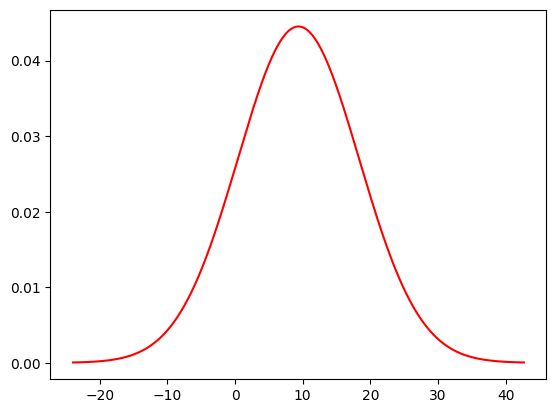

In [125]:
a,b= norm.fit(np.sort(out))
g5xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), 4000)
g5distr_torch=norm.pdf(g5xtorch, a,b)
plt.plot(g5xtorch,g5distr_torch,c='r')

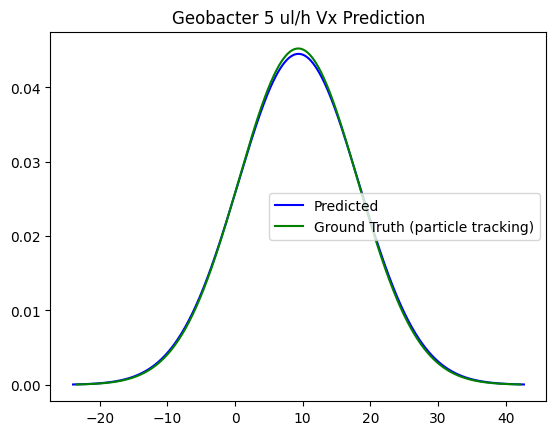

In [126]:
a,b= norm.fit(np.sort(vels))
g5xvel= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), 1000)
g5distr_vel=norm.pdf(g5xvel, a,b)
plt.plot(g5xtorch,g5distr_torch,c='b')
plt.plot(g5xvel,g5distr_vel,c='g')

plt.title('Geobacter 5 ul/h Vx Prediction')
plt.legend(['Predicted', 'Ground Truth (particle tracking)'])

## Vy

In [127]:
model0 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model0.load_state_dict(torch.load('models/vy_model_volod1_384px_disp_all_max69_2162_min-66_9786_v3'))
model0.to(device).eval()

model1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model1.load_state_dict(torch.load('models/vy_model_volod1_384px_disp_all_max69_2162_min-66_9786_v2'))
model1.to(device).eval()

model2 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model2.load_state_dict(torch.load('models/vy_model_volod1_384px_disp_all_max69_2162_min-66_9786'))
model2.to(device).eval()

model3 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model3.load_state_dict(torch.load('models/vy_model_volod1_224px_disp_all_max69_2162_min-66_9786'))
model3.to(device).eval()

model4 = timm.create_model('volo_d4_448', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model4.load_state_dict(torch.load('models/vy_model_volod4_448px_disp_all_max64_4513_min-66_1406'))
model4.to(device).eval()

model5 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model5.load_state_dict(torch.load('models/vy_model_volod1_384px_disp_all_4_27'))
model5.to(device).eval()

VOLO(
  (patch_embed): PatchEmbed(
    (conv): Sequential(
      (0): Conv2d(40, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (proj): Conv2d(64, 192, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (network): ModuleList(
    (0): Sequential(
      (0): Outlooker(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): OutlookAttention(
          (v): Linear

In [158]:
import torchvision
outputs=[]
outputs2=[]
torch.cuda.empty_cache()
gc.collect()
model0.eval()
model1.eval()
model2.eval()
model3.eval()
model4.eval()
model5.eval()


# print (slope200, slope300, slope500, slope_all)
# print (int200, int300, int500, int_all)
# tensor(182.7808) tensor(182.7808) tensor(184.0055) tensor(216.6908)
# tensor(-16.0141) tensor(-16.0141) tensor(-17.2388) tensor(-49.9241)
max1 = 69.2162
min1 = -66.9786
slope1 = max1-min1
int1 = min1

max2 = 64.4513
min2 = -66.1406
slope2 = max2-min2
int2 = min2

with torch.no_grad():
    for x in test_dataloader:
        x1 = torchvision.transforms.functional.resize(x, 448)
        x2 = torchvision.transforms.functional.resize(x, 384)
        x3 = torchvision.transforms.functional.resize(x, 224)
        out0 = np.sort(model0((x2).to(device)).detach().cpu().numpy())*slope1+int1
        out1 = np.sort(model1((x2).to(device)).detach().cpu().numpy())*slope1+int1
        out2 = np.sort(model2((x2).to(device)).detach().cpu().numpy())*slope1+int1
        out3 = np.sort(model3((x3).to(device)).detach().cpu().numpy())*slope1+int1
        out4 = np.sort(model4((x1).to(device)).detach().cpu().numpy())*slope2+int2
        out4_2 = out4*1.55-3.5
        out4_3 = out4*.75
        out5 = np.sort(model5((x2).to(device)).detach().cpu().numpy())*slope2+int2
        out5_2 = np.sort(model5((x2).to(device)).detach().cpu().numpy())*slope1+int1

        
        ##class1
        #if class_num==1:
        out=(out0+out1+out2+out3+out4*30+out5+out5_2+out4_2*22)/58

        ##class3
        #out=(out0*18+out1*4+out4*1+out2*2+out8*6)/31

        ##class4
        #out=(out0*10+out1*14+out9*2)/27

        outputs.append(out)
        #outputs2.append(out2)

In [159]:
outputs = np.reshape(np.hstack(outputs),[40000  ,])


In [ ]:
directory='../tmate_trajectories/'
filename = os.listdir(directory)[4]
print(filename)
df = pd.read_csv(os.path.join(directory,filename),header=0, skiprows=[1,2,3])
#df.Positio
tracks = df.TRACK_ID.unique()
vels=1
for i in range(len(tracks)):
    idx = tracks[i]
    if df[df.TRACK_ID==idx].sort_values(by='FRAME').FRAME.iloc[-1] < (images.shape[0]*images.shape[1]):
        posy = df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_Y
        yvel = calculate_velocity(np.array(posy))
        
        #posx[posx==0]=np.nan
        #posy[posy==0]=np.nan
        #vel = (np.sqrt(posx.diff()**2+posy.diff()**2)/.12).dropna()
    
        vels = np.hstack([vels, yvel])
vels=vels[~np.isnan(vels)]

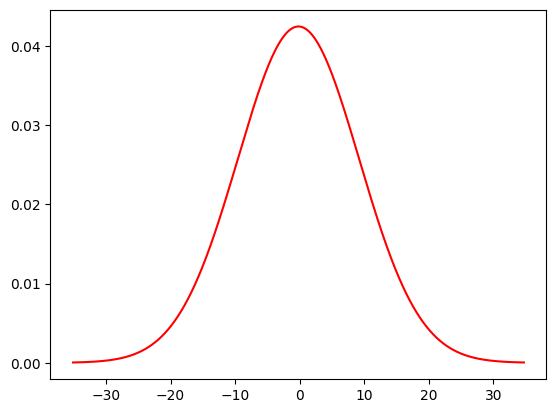

In [160]:
a,b= norm.fit(np.sort(outputs))
g5xtorch= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), 4000)
g5distr_torch=norm.pdf(g5xtorch, a,b)
plt.plot(g5xtorch,g5distr_torch,c='r')

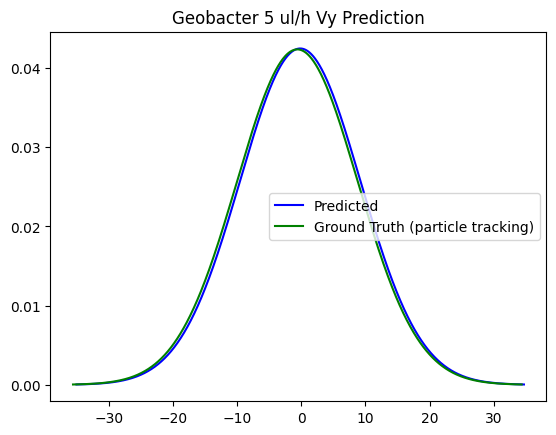

In [161]:
from scipy.stats import exponweib,lognorm, beta, betaprime, norm

a,b= norm.fit(np.sort(vels))
g5xvel= np.linspace(norm.ppf(0.0001, a,b),
                norm.ppf(0.9999, a,b), 1000)
g5distr_vel=norm.pdf(g5xvel, a,b)
plt.plot(g5xtorch,g5distr_torch,c='b')
plt.plot(g5xvel,g5distr_vel,c='g')

plt.title('Geobacter 5 ul/h Vy Prediction')
plt.legend(['Predicted', 'Ground Truth (particle tracking)'])

# MSD

In [173]:
base='all_traj_files/'
target_length=500
def calculate_msd(x_positions, y_positions):
    num_frames = len(x_positions)
    # Initialize an array to store the MSD values
    msd = np.zeros(num_frames)
    # Calculate the displacement for each particle at each frame
    for frame in range(num_frames):
        x_displacements = x_arr[frame] - x_arr[0]
        y_displacements = x_arr[frame] - x_arr[0]
        
        # Calculate the squared displacement for each particle
        squared_displacements = x_displacements**2 + y_displacements**2
        
        # Calculate the MSD for the current frame
        msd[frame] = np.nanmean(squared_displacements)
    
    return msd

# angles = torch.zeros(len(train_dirs),target_length)
# for i in range(len(train_dirs)):
#     x_arr= np.array(pd.read_csv(base+train_dirs[i][1], header=None))
#     y_arr= np.array(pd.read_csv(base+train_dirs[i][0], header=None))
#     angle_array = calculate_msd(x_arr,y_arr)
#     angle_array = np.sort(angle_array)
#     angle_array=(angle_array[~np.isnan(angle_array)])
#     if len(angle_array)==0:
#         print(i)
#     else:
#         angle_array = interpolate_vectors(np.sort(angle_array), target_length)
#         angles[i,:] = torch.tensor(angle_array)

In [185]:
model0 = timm.create_model('volo_d1_224', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model0.load_state_dict(torch.load('models/MSD_model_volod1_224px_disp_all_4_27'))
model0.to(device).eval()

model1 = timm.create_model('volo_d1_384', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model1.load_state_dict(torch.load('models/MSD_model_volod1_384px_disp_all_max_1363419_2'))
model1.to(device).eval()


model2 = timm.create_model('volo_d3_448', in_chans=40, drop_path_rate=.0,num_classes=500,pretrained=False)
model2.load_state_dict(torch.load('models/MSD_model_volod3_448px_disp_all_4_27'))
model2.to(device).eval()


VOLO(
  (patch_embed): PatchEmbed(
    (conv): Sequential(
      (0): Conv2d(40, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (proj): Conv2d(64, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (network): ModuleList(
    (0): Sequential(
      (0): Outlooker(
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): OutlookAttention(
          (v): Linear

In [243]:
directory='../tmate_trajectories/'
filename = os.listdir(directory)[4]
print(filename)
df = pd.read_csv(os.path.join(directory,filename),header=0, skiprows=[1,2,3])
#df.Positio
tracks = df.TRACK_ID.unique()
msds=np.zeros([len(tracks),500])
for i in range(len(tracks)):
    idx = tracks[i]
    if df[df.TRACK_ID==idx].sort_values(by='FRAME').FRAME.iloc[-1] < (images.shape[0]*images.shape[1]):
        posy = df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_Y
        posx = df[df.TRACK_ID==idx].sort_values(by='FRAME').POSITION_X
        if np.all(posx==0):
            continue
        else:
            x_arr= np.array(posx)
            y_arr= np.array(posy)
            msd_array = calculate_msd(x_arr,y_arr)
            #msd_array = np.sort(msd_array)
            msd_array=(msd_array[~np.isnan(msd_array)])
            msd_array = msd_array[msd_array>0]
            msd_array = interpolate_vectors(np.sort(msd_array), target_length)
            msds[i,:] = msd_array


geo_5ulh_001.csv


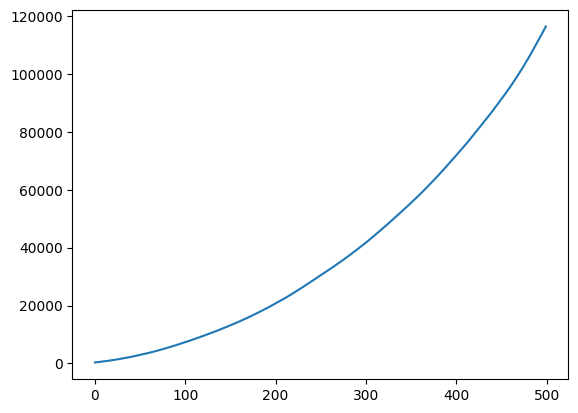

In [245]:
msds.shape
mean_msd = np.mean(msds,0)
plt.plot(mean_msd)

In [362]:
import torchvision
outputs=[]
outputs2=[]
torch.cuda.empty_cache()
gc.collect()
model0.eval()
model1.eval()
model2.eval()



# print (slope200, slope300, slope500, slope_all)
# print (int200, int300, int500, int_all)
# tensor(182.7808) tensor(182.7808) tensor(184.0055) tensor(216.6908)
# tensor(-16.0141) tensor(-16.0141) tensor(-17.2388) tensor(-49.9241)
max1 = 1300000


with torch.no_grad():
    for x in test_dataloader:
        x1 = torchvision.transforms.functional.resize(x, 448)
        x2 = torchvision.transforms.functional.resize(x, 384)
        x3 = torchvision.transforms.functional.resize(x, 224)
        out0 = np.sort(model0((x3).to(device)).detach().cpu().numpy())*max1
        out1 = np.sort(model1((x2).to(device)).detach().cpu().numpy())*max1
        out2 = np.sort(model2((x1).to(device)).detach().cpu().numpy())*max1


        
        ##class1
        #if class_num==1:
        out=(out0*2+out1*14+out2*1)/17+7550
        out[:,0:400] = (out[:,0:400]+.75*out0[:,0:400])/1.75
        out[:,400:] = (out[:,400:]+.25*out1[:,400:])/1.25
        out = out*.95+1100

        ##class3
        #out=(out0*18+out1*4+out4*1+out2*2+out8*6)/31

        ##class4
        #out=(out0*10+out1*14+out9*2)/27

        outputs.append(out)
        #outputs2.append(out2)

In [363]:
out.shape

(10, 500)

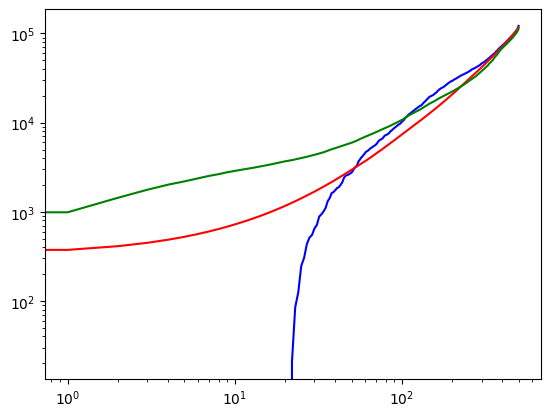

In [364]:
plt.plot(np.mean(out1,0),c='b')
plt.plot(mean_msd,c='r')
plt.plot(np.mean(np.vstack(outputs),0),c='g')
plt.xscale('log')
plt.yscale('log')

In [361]:
np.mean(np.vstack(outputs),0)

array([   480.47811272,   1388.33069129,   1838.08626603,   2169.38684001,
         2419.1561112 ,   2595.35817695,   2768.49930921,   2927.9839733 ,
         3045.77511145,   3176.16492737,   3277.2447626 ,   3368.78680507,
         3449.40934545,   3528.32051668,   3608.75340445,   3691.66499651,
         3767.43095301,   3853.20160612,   3931.67829088,   4016.45161852,
         4084.12009369,   4138.09962999,   4200.48544764,   4270.58531156,
         4342.48189108,   4407.48139502,   4478.24511363,   4546.1217473 ,
         4617.01612701,   4686.56738247,   4758.64485886,   4830.87466617,
         4908.9328019 ,   4982.54457642,   5058.78472321,   5153.49360737,
         5256.31154266,   5329.03014361,   5434.21826318,   5506.82561225,
         5585.18343306,   5666.99662006,   5735.95860354,   5821.35464858,
         5900.98056756,   5982.77355386,   6060.95087505,   6133.49601439,
         6201.99191867,   6274.41751134,   6351.51585306,   6435.66757074,
         6533.94489305,  

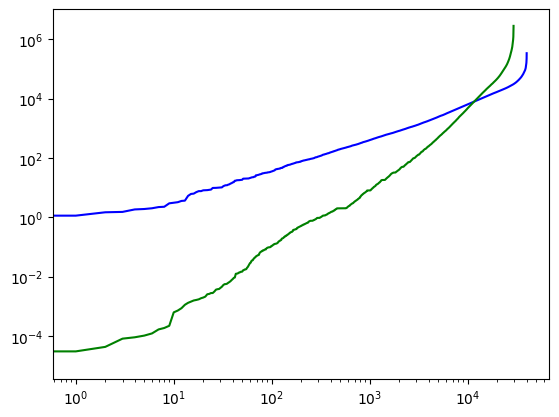

In [226]:
outputs2 = interpolate_vectors(outputs, len(msds))
plt.plot(np.sort(outputs), c='b')
plt.plot(np.sort(msds), c='g')
plt.xscale('log')
plt.yscale('log')

In [227]:
len(msds)

29386

In [201]:
outputs

array([-17439.092, -13038.38 , -12494.351, ..., 346081.03 , 346607.56 ,
       346771.62 ], dtype=float32)